# Introduction

### Table of Contents
* [Set Up Environment](#set-up-environment)
* [The Test Image](#the-test-image)
* [The "Application"](#the-application)
* [Black-Box Classifier](#black-box-classifier)
* [DRISE Black-Box Saliency Algorithm](#drise-black-box-saliency-algorithm)
* [MC-Rise Algorithm with Debiasing](#mc-rise-algorithm-with-debiasing)
    * [Red Fill](#red-fill)
    * [Green Fill](#green-fill)
    * [Blue Fill](#blue-fill)
    * [Black Fill](#black-fill)
    * [White Fill](#white-fill)

### Miscellaneous
License for test image used may be found in 'COCO-LICENSE.txt'.

#### References
1. Hatakeyama, Y., Sakuma, H., Konishi, Y., & Suenaga, K. (2020). Visualizing color-wise saliency of black-box image classification models. In Proceedings of the Asian Conference on Computer Vision.


# Set Up Environment
**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q "torch>=1.9.0"
!{sys.executable} -m pip install -q "torchvision>=0.10.0"

# The Test Image
We will test this application on the following image.
We know that this image contains the ImageNet classes of "boxer" and "tiger cat".

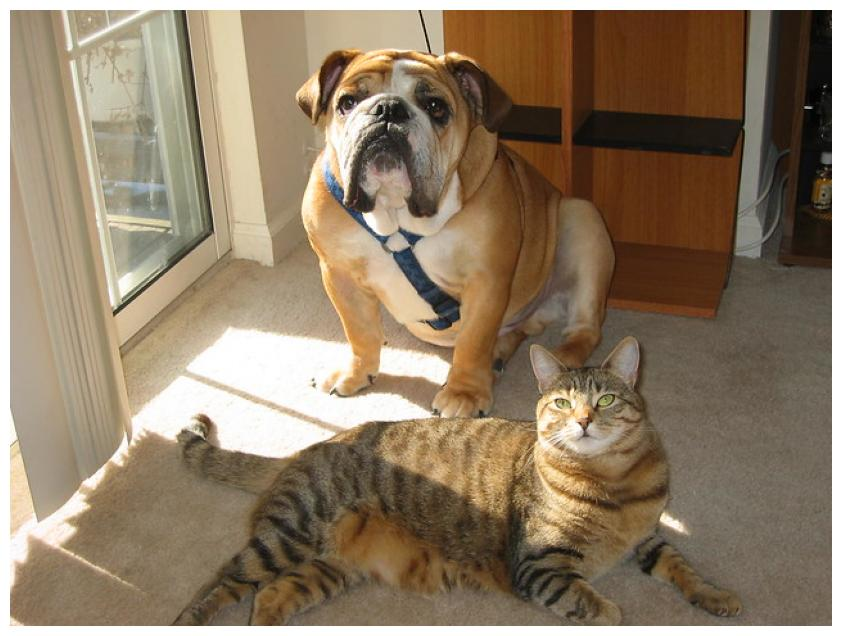

In [1]:
import os
import PIL.Image
import matplotlib.pyplot as plt
import urllib.request


# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "jpeg"


os.makedirs('data', exist_ok=True)
test_image_filename = 'data/catdog.jpg'
urllib.request.urlretrieve('https://farm1.staticflickr.com/74/202734059_fcce636dcd_z.jpg', test_image_filename)
plt.figure(figsize=(12, 8))
plt.axis('off')
_ = plt.imshow(PIL.Image.open(test_image_filename))

# The "Application"
The xaitk-saliency package provides a relatively high-level API interface for visual saliency map generation.
This interface defines the following input requirements:
  * a reference image
  * a black-box classifier that performs inference over images

As mentioned above, our high-level API accepts black-box classifiers in terms of the `ClassifyImage` interface.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
from smqtk_classifier import ClassifyImage
from xaitk_saliency import GenerateImageClassifierBlackboxSaliency


def app(
    image_filepath: str,
    # Assuming outputs `nClass` length arrays.
    blackbox_classify: ClassifyImage,
    gen_bb_sal: GenerateImageClassifierBlackboxSaliency,
):
    # Load the image
    ref_image = np.asarray(PIL.Image.open(image_filepath))
    sal_maps = gen_bb_sal(ref_image, blackbox_classify)
    print(f"Saliency maps: {sal_maps.shape}")
    visualize_saliency(ref_image, sal_maps)


def visualize_saliency(ref_image: np.ndarray, sal_maps: np.ndarray) -> None:
    # Visualize the saliency heat-maps
    sub_plot_ind = len(sal_maps) + 1
    plt.figure(figsize=(12, 6))
    plt.subplot(2, sub_plot_ind, 1)
    plt.imshow(ref_image)
    plt.axis('off')
    plt.title('Test Image')

    # Some magic numbers here to get colorbar to be roughly the same height
    # as the plotted image.
    colorbar_kwargs = {
        "fraction": 0.046*(ref_image.shape[0]/ref_image.shape[1]),
        "pad": 0.04,
    }

    for i, class_sal_map in enumerate(sal_maps):
        print(f"Class {i} saliency map range: [{class_sal_map.min()}, {class_sal_map.max()}]")

        # Positive half saliency
        plt.subplot(2, sub_plot_ind, 2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, 0, 1),
            cmap='jet', alpha=0.3
        )
        plt.clim(0, 1)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Pos Saliency")
        plt.axis('off')

        # Negative half saliency
        plt.subplot(2, sub_plot_ind, sub_plot_ind+2+i)
        plt.imshow(ref_image, alpha=0.7)
        plt.imshow(
            np.clip(class_sal_map, -1, 0),
            cmap='jet_r', alpha=0.3
        )
        plt.clim(-1, 0)
        plt.colorbar(**colorbar_kwargs)
        plt.title(f"Class #{i+1} Neg Saliency")
        plt.axis('off')

# Black-Box Classifier
In this example, we will use a basic PyTorch-based, pretrained ResNet18 model and use its softmax output as classification confidences.
Since this model normally outputs 1000 classes, we will, for simplicity of example, constrain the output to the two classes that are relevant for our test image.

In [3]:
# Set up our "black box" classifier using PyTorch and it's ImageNet pretrained ResNet18.
# We will constrain the output of our classifier here to the two classes that are relevant
# to our test image for the purposes of this example.
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms

CUDA_AVAILABLE = torch.cuda.is_available()


model = models.resnet18(pretrained=True)
model = model.eval()
if CUDA_AVAILABLE:
    model = model.cuda()

# These are some simple helper functions to perform prediction with this model
model_input_size = (224, 224)
model_mean = [0.485, 0.456, 0.406]
model_loader = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(model_input_size),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=model_mean,
        std=[0.229, 0.224, 0.225]
    ),
])


# Grabbing the class labels associated with this model.
classes_file = "data/imagenet_classes.txt"
if not os.path.isfile(classes_file):
    !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O {classes_file}

f = open(classes_file, "r")
categories = [s.strip() for s in f.readlines()]


# For this test, we will use an image with both a cat and a dog in it.
# Let's only consider the saliency of two class predictions.
sal_class_labels = ['boxer', 'tiger cat']
sal_class_idxs = [categories.index(lbl) for lbl in sal_class_labels]


class TorchResnet18 (ClassifyImage):
    """ Blackbox model to output the two focus classes. """

    def get_labels(self):
        return sal_class_labels

    @torch.no_grad()
    def classify_images(self, image_iter):
        # Input may either be an NDaray, or some arbitrary iterable of NDarray images.

        for img in image_iter:
            image_tensor = model_loader(img).unsqueeze(0)
            if CUDA_AVAILABLE:
                image_tensor = image_tensor.cuda()
            feature_vec = model(image_tensor)
            # Converting feature extractor output to probabilities.
            class_conf = torch.nn.functional.softmax(feature_vec, dim=1).cpu().detach().numpy().squeeze()
            # Only return the confidences for the focus classes
            yield dict(zip(sal_class_labels, class_conf[sal_class_idxs]))

    def get_config(self):
        # Required by a parent class.
        return {}


blackbox_classifier = TorchResnet18()

/home/barry-ravichandran/data/envs/xaitk-saliency/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/barry-ravichandran/data/envs/xaitk-saliency/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# DRISE Black-Box Saliency Algorithm

In [4]:
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.rise import RISEStack

gen_rise_debiased = RISEStack(1000, 8, 0.5, seed=0, threads=4, debiased=True)

# MC-Rise Algorithm with Debiasing

## Red Fill

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.315435528755188, 1.0]
Class 1 saliency map range: [-0.4059816598892212, 1.0]


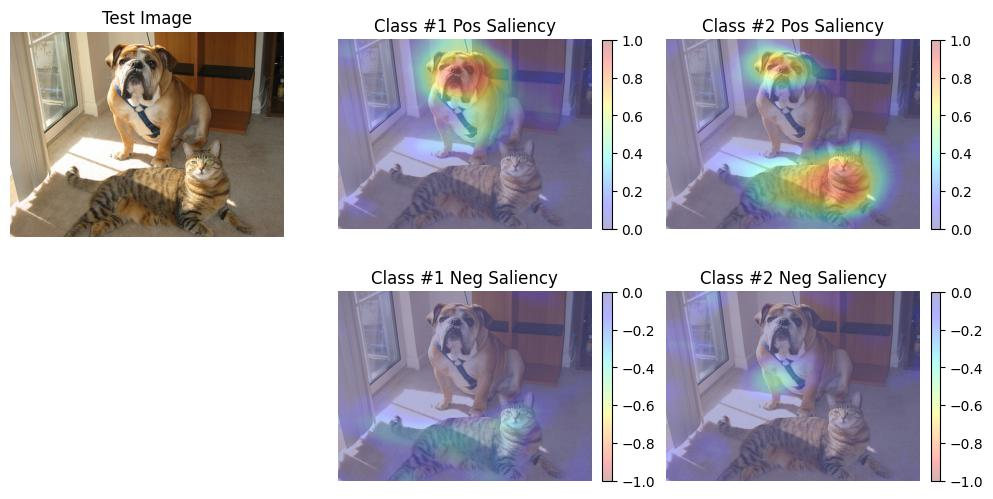

In [5]:
blackbox_fill = np.uint8(np.multiply(np.asarray(model_mean), np.asarray([255, 0, 0])))
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)

## Green Fill

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.28895774483680725, 1.0]
Class 1 saliency map range: [-0.2289266586303711, 1.0]


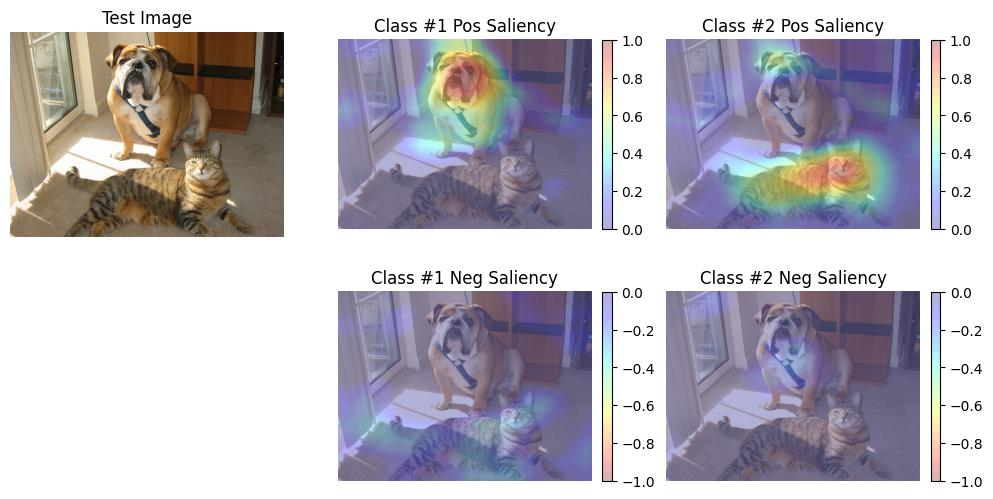

In [6]:
blackbox_fill = np.uint8(np.multiply(np.asarray(model_mean), np.asarray([0, 255, 0])))
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)

## Blue Fill

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.463528573513031, 1.0]
Class 1 saliency map range: [-0.22462747991085052, 1.0]


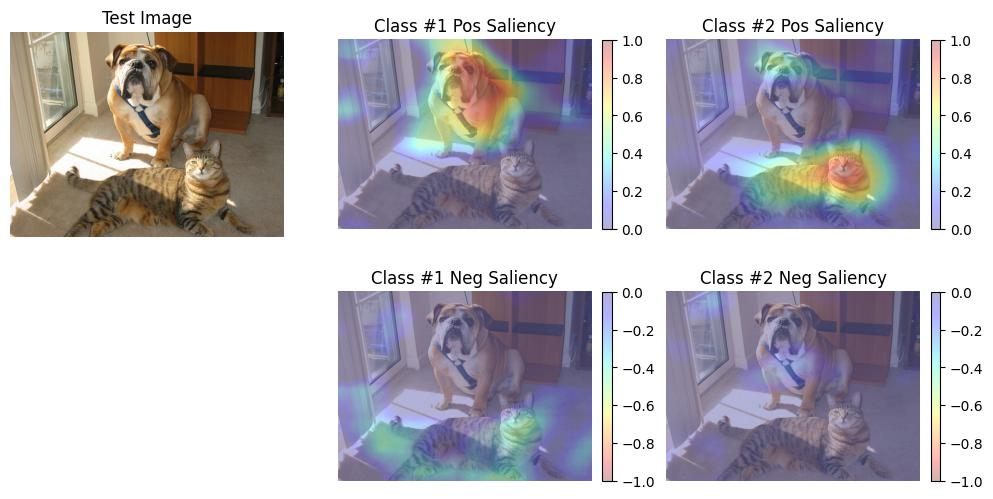

In [7]:
blackbox_fill = np.uint8(np.multiply(np.asarray(model_mean), np.asarray([0, 0, 255])))
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)

## Black Fill

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.6637169122695923, 1.0]
Class 1 saliency map range: [-0.43466123938560486, 1.0]


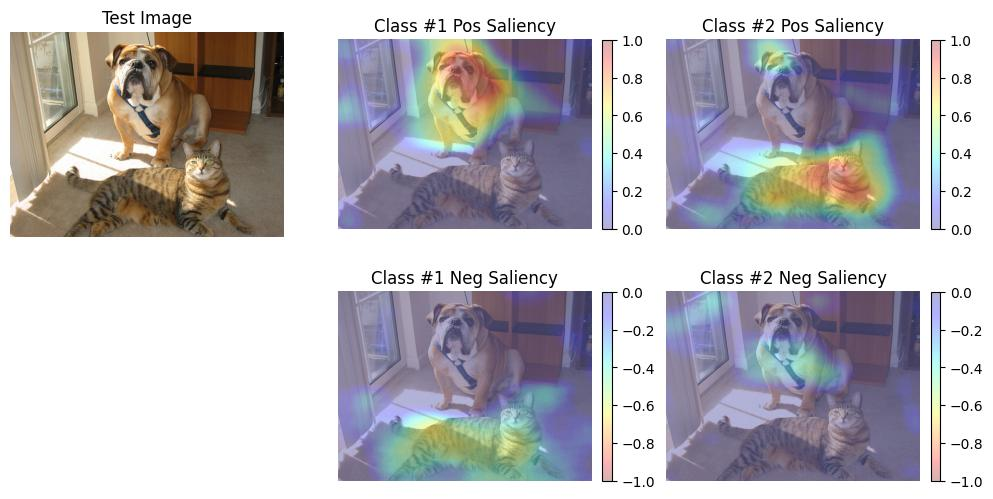

In [8]:
blackbox_fill = np.uint8(np.multiply(np.asarray(model_mean), np.asarray([0, 0, 0])))
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)

## White Fill

Saliency maps: (2, 480, 640)
Class 0 saliency map range: [-0.5117952823638916, 1.0]
Class 1 saliency map range: [-0.4980420768260956, 1.0]


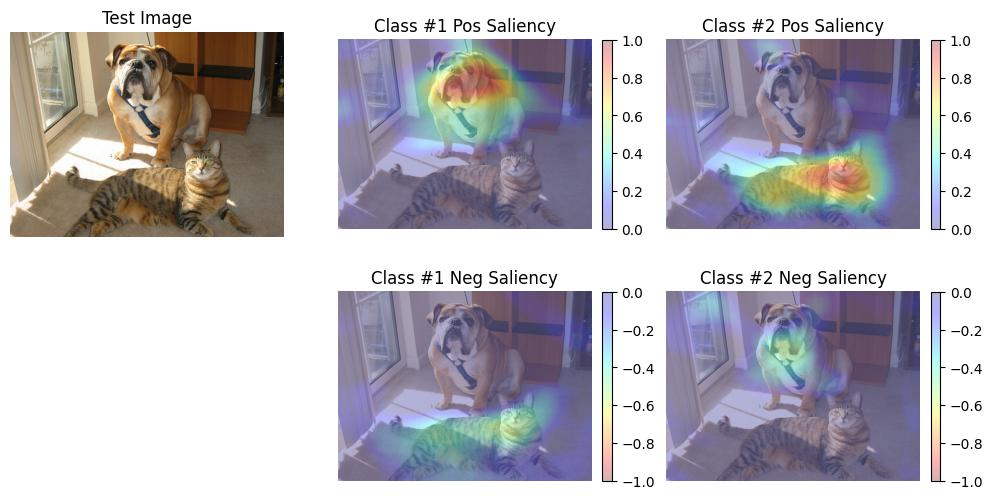

In [9]:
blackbox_fill = np.uint8(np.multiply(np.asarray(model_mean), np.asarray([255, 255, 255])))
gen_rise_debiased.fill = blackbox_fill

app(
    test_image_filename,
    blackbox_classifier,
    gen_rise_debiased,
)